# Quick Start
Run through the API for common tasks in ML
Refer to the links in each section to dive deeper

## Working with data
Pytorch has 2 primitive to work with data:
*torch.utils.data.DataLoader*
*torch.utils.data.Dataset*

**Dataset** stores the samples and their corresponding labels, and **DataLoader** wraps an iterable around the **Dataset**.

In [9]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

PyTorch offers domain-specific libraries such as **TorchText**, **TorchVision**, and **TorchAudio**, all of which include datasets.

For this tutorial, we will be using a **TorchVision** dataset.

In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root = 'data',
    train = True,
    download = False,
    transform = ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root = 'data',
    train = False,
    download = False,
    transform = ToTensor(),
)

We pass the **Dataset** as an argument to **DataLoader**.
This warps an iterable over our dataset, and supports automatic batching, shuffling and multi-process data loading.
Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size = batch_size)
test_dataloader = DataLoader(test_data, batch_size = batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


# Creating Models

To define a neural network in PyTorch, we create a class that inherits from [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). We define the layers of the network in the __init__ function and specify how data will pass through the network in the **forward** function.

To accelerate operations in the neural network, we move it to the GPU if available.

In [4]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model 
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


# Optimizing the Model Parameters
To train a model, we need a [**loss function**](https://pytorch.org/docs/stable/nn.html#loss-functions) and an [**optimizer**](https://pytorch.org/docs/stable/optim.html)

In [5]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and backpropagates the prediction error to adjust the model’s parameters.

In [6]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):

        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Bp
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if batch % 100 == 0:
        loss, current = loss.item(), batch * len(X)
        print(f"loss: {loss:>7} [{current:>5d}/{size:>5d}")

check the model's performance against the test dataset to ensure it is learning

In [7]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

The training process is conducted over several iterations(*epochs*). During each epoch, the model learns parameters to make better predictions. 
We print the model's accuracy and loss at each epoch, we'd like to see the accuracy increase and the loss decrease with every epoch.

In [8]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print('Done!')

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 37.0%, Avg loss: 2.144379 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 50.1%, Avg loss: 1.857326 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 59.5%, Avg loss: 1.491992 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 63.1%, Avg loss: 1.242166 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 64.6%, Avg loss: 1.086394 

Done!


# Saving Models
save a model is to serialize the internal state dictionary

In [9]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


# Loading Models

The process for loading a model includes **re-creating** the model structure and **loading** the state dictionary into it

In [10]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

This model can now be used to make predictions

In [11]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted:"{predicted}", Actual: "{actual}"')

Predicted:"Ankle boot", Actual: "Ankle boot"


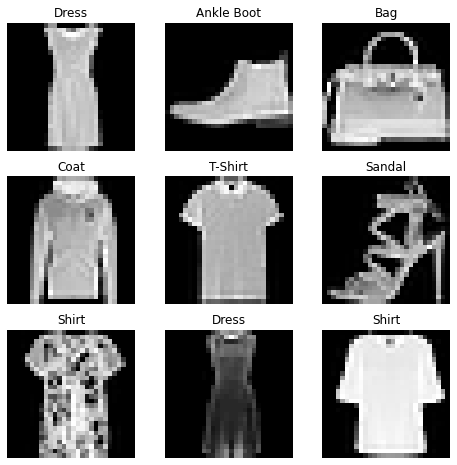

In [11]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()